In [50]:
import sys
import os
sys.path.append("../") 

In [51]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [52]:
import os
from pathlib import Path
import re

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [53]:
from config import (IMAGE_DATA_DIR, GT_DIR, IMAGE_DATA_TILES_DIR, GT_TILES_DIR, 
                    GT_ADJ_TILES_DIR, TILES_DIR, LABELS, RED, BLACK, N1, N2, N_validation,
                    CODES
                   )
from loss_custom import WeakCrossEntropy
from metrics_custom import acc_satellite, acc_weakly

In [54]:
# https://docs.fast.ai/dev/test.html#getting-reproducible-results

seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [55]:
BASE_DIR = Path('').absolute().parent; BASE_DIR

PosixPath('/home/jupyter/weakly-supervised-semseg')

# Fully-supervised (FS) Semantic Segmentation

In [56]:
gt_tiles_dir = GT_ADJ_TILES_DIR

In [57]:
image_tiles_fnames = os.listdir(BASE_DIR / IMAGE_DATA_TILES_DIR)

In [58]:
fname = image_tiles_fnames[0]

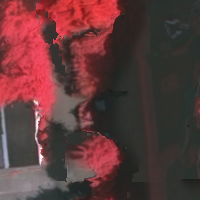

In [59]:
open_image( BASE_DIR / IMAGE_DATA_TILES_DIR / fname)

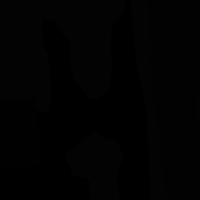

In [60]:
open_image(BASE_DIR / gt_tiles_dir / fname)

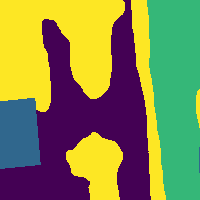

In [61]:
mask = open_mask(BASE_DIR / gt_tiles_dir / fname)
# mask.show(figsize=(5,5), alpha=1)
mask

In [62]:
src_size = np.array(mask.shape[1:])

### Load data

In [63]:
def get_y_fn(x):
    return BASE_DIR / gt_tiles_dir / x.name

In [64]:
free = gpu_mem_get_free_no_cache(); free

12173

In [65]:
base_path = "top_mosaic_09cm_area"
prog = re.compile(fr"{base_path}(?P<area_id>\d+)_tile(?P<tile_id>\d+).tif")

def is_in_set(x, N):
    fname = x.name  # e.g.: top_mosaic_09cm_area30_tile120.tif'

    match_result = prog.search(fname)
    area_id = match_result.group('area_id')
    tile_id = match_result.group('tile_id')
    image_fname = f"{base_path}{area_id}.tif"  # e.g.: top_mosaic_09cm_area30.tif'
    return image_fname in N

is_in_set_n1 = partial(is_in_set, N=N1)
is_in_set_n2 = partial(is_in_set, N=N2)
is_in_set_nvalidation = partial(is_in_set, N=N_validation)
is_in_set_n1_or_nvalidation = partial(is_in_set, N=N1+N_validation)

codes = LABELS+[RED, BLACK]

src_size = np.array(mask.shape[1:])
src_size,mask.data
# size = src_size // 2  # TODO
size = src_size

fs_item_list = (SegmentationItemList.from_folder(BASE_DIR / IMAGE_DATA_TILES_DIR)  #returns SegmentationItemList
             .filter_by_func(is_in_set_n1_or_nvalidation)  #returns SegmentationItemList
             .split_by_valid_func(is_in_set_nvalidation)  #returns ItemLists(SegmentationItemList, SegmentationItemList)
             .label_from_func(get_y_fn, classes=codes)  #returns LabelLists(LabelList, SegmentationItemList)
             .transform(get_transforms(), size=size, tfm_y=True)
            )

In [66]:
bs = 64
fs_data = fs_item_list.databunch(bs=bs).normalize(imagenet_stats)

## Model

Train and compare semantic segmentation networks, using the following data: Task (i) N1 pixel level labels

In [67]:
wd=0.1

In [68]:
# lr_find(fs_learn)
# fs_learn.recorder.plot()

In [69]:
fs_learn = unet_learner(fs_data, 
                        models.resnet18, 
                        metrics=acc_satellite, 
                        wd=wd, 
                        model_dir='/home/jupyter/weakly-supervised-semseg/models'
                       )

In [70]:
fs_lr=3e-4

In [71]:
# Uncomment for 1st time use

fs_learn.fit_one_cycle(30, slice(fs_lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_satellite,time
0,2.358374,1.940153,0.181174,00:14
1,2.093847,1.721213,0.273752,00:14
2,1.929242,1.655161,0.300811,00:14
3,1.807309,1.489045,0.426565,00:14
4,1.688300,1.328960,0.501188,00:14
5,1.566589,1.145710,0.566432,00:14
6,1.448417,1.033118,0.630905,00:14
7,1.348336,0.963771,0.654882,00:14
8,1.260127,0.860153,0.682569,00:14
9,1.183617,0.826856,0.692897,00:14


In [139]:
# Uncomment for 1st time use

fs_learn.save('mixed-stage-1')

# Weakly-supervised (WS) Semantic Segmentation

In [22]:
image_tiles_fnames = os.listdir(BASE_DIR / TILES_DIR)

In [23]:
fname = image_tiles_fnames[0]; fname

'top_mosaic_09cm_area27_tile154_11100.tif'

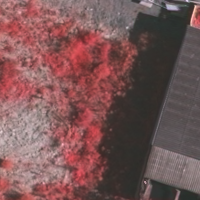

In [24]:
img = open_image(BASE_DIR / TILES_DIR / fname)
img

In [25]:
src_size = np.array(img.shape[1:]); src_size

array([200, 200])

### Load data

In [26]:
base_path = "top_mosaic_09cm_area"
prog_label_vector = re.compile(base_path + r"\d+_tile\d+_(?P<label_vector>\d{5}).tif")

def get_y_fn(x):
    fname = x.name
    match_result = prog_label_vector.search(fname)
    label_vector = match_result.group('label_vector')
    label_vector_arr = torch.tensor(list(map(int,label_vector))) # NEW

    indexes = torch.where(label_vector_arr == 1)[0]
    colors = [LABELS[idx] for idx in indexes]
    
    assert 0<len(indexes)<6, (len(indexes), x)
    
    return colors

def has_a_valid_color(x):
    fname = x.name
    match_result = prog_label_vector.search(fname)
    label_vector = match_result.group('label_vector')
    label_vector_arr = torch.tensor(list(map(int,label_vector))) # NEW

    indexes = torch.where(label_vector_arr == 1)[0]
    if not (0<len(indexes)<6):
        print("not valid color", len(indexes), x)
        return False
    return True


In [27]:
free = gpu_mem_get_free_no_cache(); free

15521

In [28]:
base_path = "top_mosaic_09cm_area"
prog_with_label_vector = re.compile(base_path + r"(?P<area_id>\d+)_tile(?P<tile_id>\d+)_(?P<label_vector>\d{5}).tif")

def is_in_set(x, N):
    fname = x.name  # e.g.: top_mosaic_09cm_area30_tile120.tif'

    match_result = prog_with_label_vector.search(fname)
    area_id = match_result.group('area_id')
    tile_id = match_result.group('tile_id')
    image_fname = f"{base_path}{area_id}.tif"  # e.g.: top_mosaic_09cm_area30.tif'
    return image_fname in N

is_in_set_n1 = partial(is_in_set, N=N1)
is_in_set_n2 = partial(is_in_set, N=N2)
is_in_set_nvalidation = partial(is_in_set, N=N_validation)
is_in_set_n1_or_nvalidation = partial(is_in_set, N=N1+N_validation)
is_in_set_n2_or_nvalidation = partial(is_in_set, N=N2+N_validation)

src_size = np.array(img.shape[1:])
# size = src_size // 2  # TODO
size = src_size

codes = LABELS+[RED, BLACK]

ws_item_list = (ImageList.from_folder(BASE_DIR / TILES_DIR)  #returns ImageList
             .filter_by_func(is_in_set_n2_or_nvalidation)  #returns ImageList
             .filter_by_func(has_a_valid_color)            #returns ImageList
             .split_by_valid_func(is_in_set_nvalidation)  #returns ItemLists(ImageList, ImageList)
             .label_from_func(get_y_fn, classes=codes)  #returns LabelLists(ImageList, MultiCategoryList)
             .transform(get_transforms(), size=size)
            )

not valid color 0 /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_weaklabel_tiles/top_mosaic_09cm_area26_tile46_00000.tif


In [29]:
bs = 64
ws_data = ws_item_list.databunch(bs=bs).normalize(imagenet_stats)

## Model

Train and compare semantic segmentation networks, using the following data: Task (i) N1 pixel level labels

In [30]:
wd=0.1

In [31]:
# https://forums.fast.ai/t/transfer-learning-twice/43699/5
ws_learn = unet_learner(ws_data, 
                        models.resnet18, 
                        loss_func=WeakCrossEntropy(CODES, axis=1),
                        metrics=acc_weakly, 
                        wd=wd,
                        model_dir='/home/jupyter/weakly-supervised-semseg/models',
                       )
ws_learn.load('mixed-stage-1');

In [32]:
# lr_find(ws_learn)
# ws_learn.recorder.plot()

In [33]:
ws_lr=1e-4

In [34]:
ws_learn.fit_one_cycle(20, slice(ws_lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_weakly,time
0,0.212817,0.116528,0.950586,01:01
1,0.127915,0.089819,0.956003,00:51
2,0.100824,0.082679,0.961709,00:51
3,0.085788,0.082754,0.961256,00:51
4,0.075626,0.065212,0.969615,00:51
5,0.069148,0.060624,0.972452,00:51
6,0.058517,0.054170,0.975982,00:51
7,0.051016,0.054285,0.977862,00:51
8,0.053492,0.054592,0.976771,00:51
9,0.049549,0.050064,0.977234,00:51


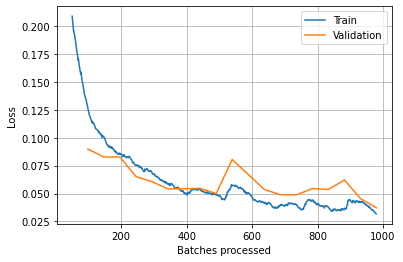

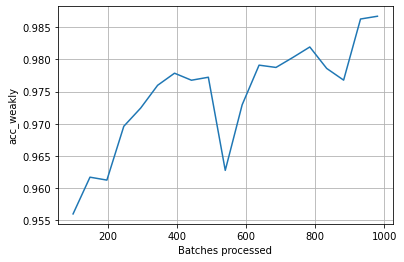

In [35]:
ws_learn.recorder.plot_losses(skip_start=50, show_grid=True)
ws_learn.recorder.plot_metrics(skip_start=50, show_grid=True)

In [36]:
ws_learn.save('mixed-stage-2')

In [ ]:
# ws_learn.load('mixed-stage-2');

In [37]:
ws_learn.load('mixed-stage-2');
loss, accuracy_weakly = ws_learn.validate(dl=ws_data.valid_dl, callbacks=None, metrics=[acc_weakly])
accuracy_weakly

tensor(0.9867)

In [38]:
fs_learn.load('mixed-stage-1');
loss, accuracy_satellite = fs_learn.validate(dl=fs_data.valid_dl, callbacks=None, metrics=[acc_satellite])
accuracy_satellite

tensor(0.7777)

In [39]:
fs_learn.load('mixed-stage-2');
loss, accuracy_satellite = fs_learn.validate(dl=fs_data.valid_dl, callbacks=None, metrics=[acc_satellite])
accuracy_satellite

tensor(0.6558)

In [40]:
fs_learn.fit_one_cycle(20, slice(fs_lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_satellite,time
0,3.260401,2.655127,0.687650,00:14
1,2.503458,1.506576,0.635189,00:14
2,2.048835,1.083009,0.639195,00:14
3,1.729178,0.950266,0.678552,00:14
4,1.523092,0.914773,0.643814,00:14
5,1.376379,0.843217,0.644383,00:14
6,1.251946,0.730456,0.699935,00:14
7,1.143635,0.673582,0.735635,00:14
8,1.049552,0.656466,0.748003,00:14
9,0.973104,0.659182,0.744513,00:14


In [41]:
fs_learn.save('mixed-stage-3');

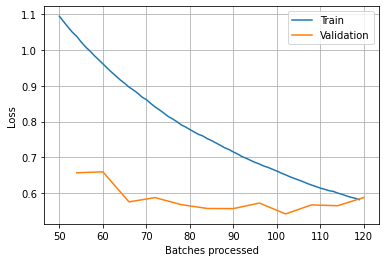

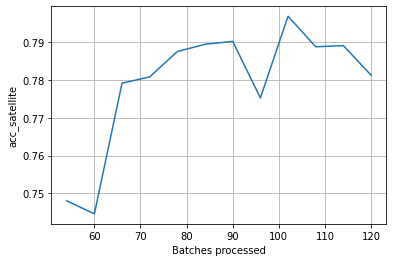

In [42]:
fs_learn.recorder.plot_losses(skip_start=50, show_grid=True)
fs_learn.recorder.plot_metrics(skip_start=50, show_grid=True)

In [43]:
ws_learn.load('mixed-stage-3');
loss, accuracy_weakly = ws_learn.validate(dl=ws_data.valid_dl, callbacks=None, metrics=[acc_weakly])
accuracy_weakly

tensor(0.9146)

In [44]:
ws_lr_slice = slice(1e-4)
fs_lr_slice = slice(3e-4)

In [45]:
should_train_supervised = False  # alternating flag
last_save_location = 'mixed-stage-loop'

ws_learn.load('mixed-stage-1');
ws_learn.save(last_save_location);

for i in range(10): # even s.t. FS is trained last
    print(i, "should_train_supervised: ", should_train_supervised)
    current_learn = fs_learn if should_train_supervised else ws_learn
    current_lr = fs_lr_slice if should_train_supervised else ws_lr_slice
        
    current_learn.load(last_save_location);
    current_learn.fit_one_cycle(1, current_lr, pct_start=0.9)
    current_learn.save(last_save_location);
    
    should_train_supervised = not should_train_supervised

0 should_train_supervised:  False


epoch,train_loss,valid_loss,acc_weakly,time
0,0.151127,0.095076,0.952245,00:51


1 should_train_supervised:  True


epoch,train_loss,valid_loss,acc_satellite,time
0,0.965289,0.716274,0.746487,00:14


2 should_train_supervised:  False


epoch,train_loss,valid_loss,acc_weakly,time
0,0.160984,0.093697,0.960517,00:51


3 should_train_supervised:  True


epoch,train_loss,valid_loss,acc_satellite,time
0,0.908507,0.813607,0.729607,00:14


4 should_train_supervised:  False


epoch,train_loss,valid_loss,acc_weakly,time
0,0.112500,0.081436,0.963359,00:51


5 should_train_supervised:  True


epoch,train_loss,valid_loss,acc_satellite,time
0,0.803125,0.772246,0.766765,00:14


6 should_train_supervised:  False


epoch,train_loss,valid_loss,acc_weakly,time
0,0.099335,0.078864,0.968356,00:51


7 should_train_supervised:  True


epoch,train_loss,valid_loss,acc_satellite,time
0,0.828987,0.885125,0.663215,00:14


8 should_train_supervised:  False


epoch,train_loss,valid_loss,acc_weakly,time
0,0.115476,0.081446,0.964244,00:51


9 should_train_supervised:  True


epoch,train_loss,valid_loss,acc_satellite,time
0,0.792451,0.819208,0.738544,00:14


In [46]:
fs_learn.load(last_save_location);
loss, accuracy_satellite = fs_learn.validate(dl=fs_data.valid_dl, callbacks=None, metrics=[acc_satellite])
accuracy_satellite

tensor(0.7385)

In [47]:
fs_learn.fit_one_cycle(20, fs_lr, pct_start=0.9)

epoch,train_loss,valid_loss,acc_satellite,time
0,0.693098,0.785076,0.750590,00:14
1,0.668011,0.707750,0.780059,00:14
2,0.635814,0.647184,0.792847,00:14
3,0.610579,0.636117,0.790116,00:14
4,0.583940,0.685790,0.786254,00:14
5,0.561659,0.602820,0.789694,00:14
6,0.541729,0.608873,0.786674,00:14
7,0.524331,0.603470,0.789290,00:14
8,0.508566,0.620259,0.778234,00:14
9,0.493819,0.601086,0.784713,00:14


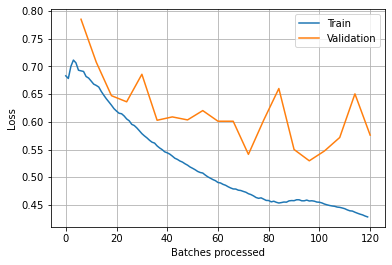

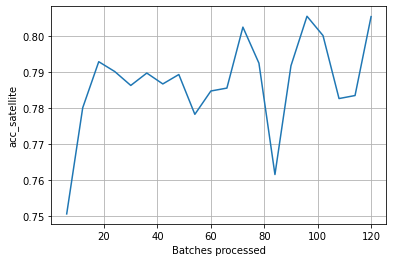

In [49]:
fs_learn.recorder.plot_losses(show_grid=True)
fs_learn.recorder.plot_metrics(show_grid=True)